In [155]:
from upload_data import *
from utils import *
import pandas as pd
import time
import dask
%reload_ext autoreload
%autoreload 2

In [145]:
%%time
#No parallelization
df = load_all_dates(ticker = 'AA.N', start_date = pd.to_datetime('2008-12-26'), end_date=pd.to_datetime('2008-12-31'))

CPU times: total: 391 ms
Wall time: 20.4 s


In [142]:
%%time
#Parallelization
df = load_all_dates(ticker = 'AA.N', start_date = pd.to_datetime('2008-12-26'), end_date=pd.to_datetime('2008-12-31'))

CPU times: total: 438 ms
Wall time: 5.37 s


In [154]:
%%time
df_ = load_all(start_date = pd.to_datetime('2008-06-01'), end_date=pd.to_datetime('2008-12-31'))



CPU times: total: 32.5 s
Wall time: 44.6 s


In [156]:
%%time
df_2 = load_all(start_date = pd.to_datetime('2008-06-01'), end_date=pd.to_datetime('2008-12-31'))

CPU times: total: 34.3 s
Wall time: 33.1 s


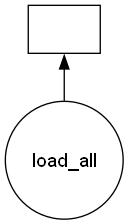

In [104]:
alldatapromices.visualize()

In [80]:
%%time
all_data = alldatapromices.compute()

CPU times: total: 6.14 s
Wall time: 4.95 s


In [91]:
#ticker="SPY.P"
ticker = "AA.N"

start_date=pd.to_datetime("2008-01-01") #"2010-01-01"
end_date=pd.to_datetime("2008-12-31") #2010-12-31"


In [97]:
%time all_data =load_all_dates(ticker = ticker, start_date = start_date, end_date = end_date)

CPU times: total: 0 ns
Wall time: 0 ns


In [98]:
%%time
all_data.compute()

TypeError: cannot concatenate object of type '<class 'dask.delayed.Delayed'>'; only Series and DataFrame objs are valid

In [111]:
import dask
import time

from joblib import delayed

def myadd(a,b):
    time.sleep(1)
    a = increment(a)
    b = increment(b)
    return a+b
@delayed
def increment(a):
    time.sleep(1)
    return a+1



In [120]:
%%time
@dask.delayed
def add(a,b):
    return a+b

a=1
b= np.arange(10)

c = [dask.delayed(add)(a,b_i) for b_i in b]

CPU times: total: 0 ns
Wall time: 0 ns


In [122]:
#compute all the promises
print(c)
results = dask.compute(*c)

print(results)

[Delayed('add-71f353f6-c8b4-47d0-8693-8b2a82924fc7'), Delayed('add-7120e4a6-3a6f-4fa2-b247-944fa16eeae0'), Delayed('add-4821a940-a60e-434f-8751-5ef441ffd7ad'), Delayed('add-09977cb6-a651-4b4d-94ac-9d25350ad189'), Delayed('add-2321bb1e-abf8-49bb-a660-19009e1a69d4'), Delayed('add-ed77b6bf-b2ca-4f44-913f-151165a41a6c'), Delayed('add-d3ec68ed-8a16-4473-a605-71c16620bd0c'), Delayed('add-91c47c72-0fed-422a-ab69-667bd66cf453'), Delayed('add-d8cc1081-9089-4b83-8670-1bbdcfcb79b9'), Delayed('add-167e0041-5670-4ead-bb55-9040776f6b4d')]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


In [114]:
%%time
c.compute()

AttributeError: 'list' object has no attribute 'compute'

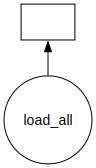

In [13]:
c.visualize(filename = 'test.svg')

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Can you read me
